# SHAP S-I-R Global Explanations

On this notebook we will review and implement the results from [Feature Synergy, Redundancy, and Independence in Global Model Explanations using SHAP Vector Decomposition](https://arxiv.org/abs/2107.12436), which proposes a new method of finding global explanations from Shap Values in a way we can improve our understanding of our datasets and models and also to generate a feature selection method.

The main interpretation here is the geometric position of the vectors grabbed from the paper:

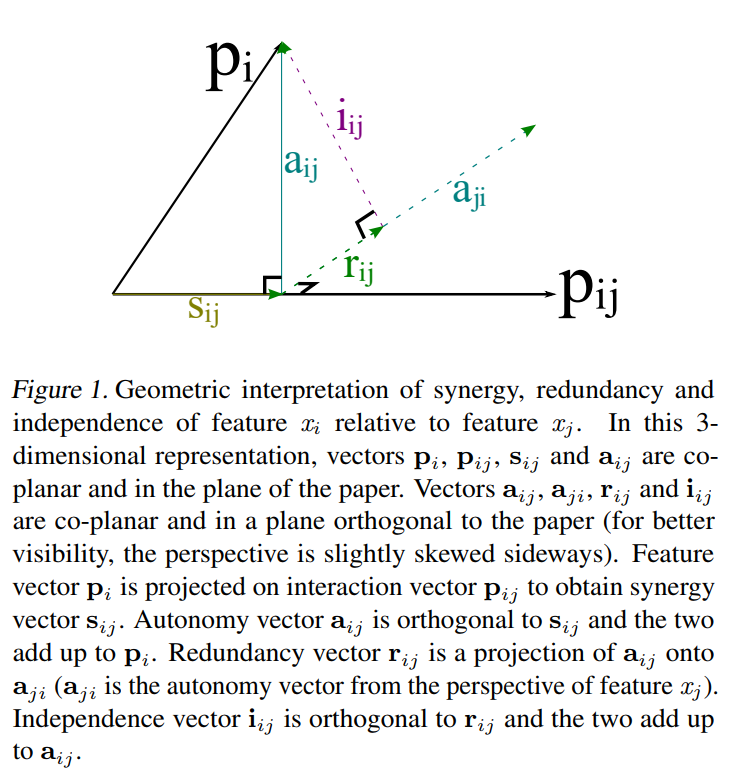

In [1]:
import shap
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier

2021-11-14 11:24:56.626095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 11:24:56.626218: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
# Get the dataset and fit a Random Forest on it
X, y = load_wine(return_X_y=True, as_frame=True)

rf = RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier()

In [3]:
# Runs the explainer on the model and the dataset to grab the Shap Values
explainer = shap.Explainer(rf)
shap_values = explainer(X)

C extension was not built during install!


Exception: The passed model is not callable and cannot be analyzed directly with the given masker! Model: RandomForestClassifier()

In [ ]:
# The return of the explainer has three matrices, we will get the shap values one
shap_values = shap_values.values[:, :, 0]

In [ ]:
# Now, let's get the interaction values
p_all = explainer.shap_interaction_values(X)[0]

In [36]:
def generate_SIR_SHAP_metrics(shap_values, shap_interaction_values):

    # Define matrices to be filled
    s = np.zeros((shap_values.shape[1], shap_values.shape[1], shap_values.shape[0]))
    a = np.zeros((shap_values.shape[1], shap_values.shape[1], shap_values.shape[0]))
    r = np.zeros((shap_values.shape[1], shap_values.shape[1], shap_values.shape[0]))
    i_ = np.zeros((shap_values.shape[1], shap_values.shape[1], shap_values.shape[0]))

    S = np.zeros((shap_values.shape[1], shap_values.shape[1]))
    R = np.zeros((shap_values.shape[1], shap_values.shape[1]))
    I = np.zeros((shap_values.shape[1], shap_values.shape[1]))

    for i in range(shap_values.shape[1]):
        # Selects the p_i vector -> Shap Values vector for feature i
        pi = shap_values[:, i]
        
        for j in range(shap_values.shape[1]):
            # Selects pij -> SHAP interaction vector between features i and j
            pij = shap_interaction_values[:, i, j]
            
            # Other required vectors
            pji = shap_interaction_values[:, j, i]
            pj = shap_values[:, j]

            # Synergy vector
            s[i, j] = (np.inner(pi, pij) / np.linalg.norm(pij)**2) * pij
            s[j, i] = (np.inner(pj, pji) / np.linalg.norm(pji)**2) * pji

            # Autonomy vector
            a[i,j] = pi - s[i, j]
            a[j,i] = pj - s[j, i]

            # Redundancy vector
            r[i,j] = (np.inner(a[i, j], a[j, i]) / np.linalg.norm(a[j, i])**2) * a[j, i]
            r[j,i] = (np.inner(a[j, i], a[i, j]) / np.linalg.norm(a[i, j])**2) * a[i, j]

            # Independece vector
            i_[i, j] = a[i, j] - r[i, j]
            i_[j, i] = a[j, i] - r[j, i]

            # Synergy value
            S[i, j] = np.linalg.norm(s[i, j])**2 / np.linalg.norm(pi)**2

            # Redundancy value
            R[i, j] = np.linalg.norm(r[i, j])**2 / np.linalg.norm(pi)**2

            # Independence value
            I[i, j] = np.linalg.norm(i_[i, j])**2 / np.linalg.norm(pi)**2
            
    return S, I, R

In [ ]:
S, I, R = generate_SIR_SHAP_metrics(shap_values, p_all)